In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import hdbscan
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

# Load in the crossmatched APOGEE DR17 and planets catalogue (cross matched on the sky using a 5 arcsec cone)

In [4]:
# LOAD THE APOGEE DATA
path = '/Users/dhortadarrington/Documents/Projects/sausaged-planet/MWM-IPL3-planets.fits'
tb = fits.open(path)
data = tb[1].data 

In [18]:
lz = data['L'][:,2]
E = data['E'][:,0]

In [19]:
np.shape(E)

(1217,)

In [20]:
alfe = data['AL_H']-data['FE_H']
mask_sausage = (alfe<-0.2)&(data['FE_H']<-0.4)
print(len(data[mask_sausage]))

5


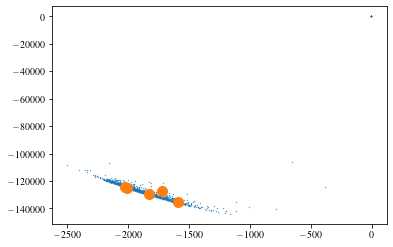

In [22]:
plt.scatter(lz,E,s=0.1)
plt.scatter(lz[mask_sausage],E[mask_sausage],s=100)

# Cross match APOGEE DR17 with the planets file

(-1, 1)

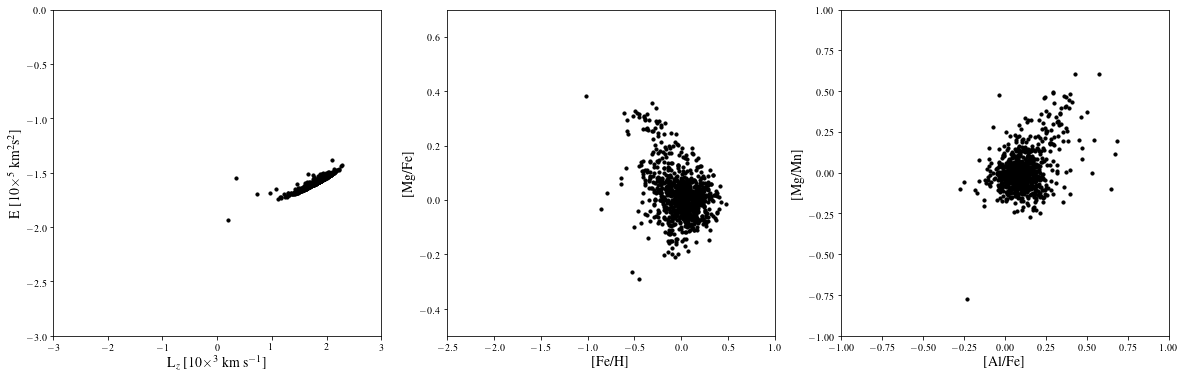

In [ ]:
# check their E-Lz distribution and abundances

plt.figure(figsize=(20,6),facecolor='white')

plt.subplot(1,3,1)
plt.scatter(lz/1e3,E/1e5,s=10,c='k')
plt.xlabel(r'L$_{z}$ [10$\times^{3}$ km s$^{-1}$]', fontsize=14)
plt.ylabel(r'E [10$\times^{5}$ km$^{2}$s$^{2}$]', fontsize=14)
plt.xlim(-3,3)
plt.ylim(-3,0)


plt.subplot(1,3,2)
plt.scatter(data['FE_H'],data['MG_FE'],s=10,c='k')
plt.xlabel(r'[Fe/H]', fontsize=14)
plt.ylabel(r'[Mg/Fe]', fontsize=14)
plt.xlim(-2.5,1)
plt.ylim(-0.5,0.7)

plt.subplot(1,3,3)
plt.scatter(data['AL_FE'],data['MG_FE']-data['MN_FE'],s=10,c='k')
plt.xlabel(r'[Al/Fe]', fontsize=14)
plt.ylabel(r'[Mg/Mn]', fontsize=14)
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.subplots_adjust(hspace=0.2,wspace=0.4)




There is a star that has IoM like GES but has no abundances. The other stars with GES-like Mg-Fe are M-dwarfs with too cool Teff to get reliable abundances

In [13]:
mask_gesplanet = data['pl_name']=='K2-65 b'

print(data['MG_FE'][mask_gesplanet])
print(data['FE_H'][mask_gesplanet])
print(data['SNR'][mask_gesplanet])
print(data['TEFF'][mask_gesplanet])
print(data['LOGG'][mask_gesplanet])
print(data['weighted_dist'][mask_gesplanet]/1e3)
print(data['weighted_dist_error'][mask_gesplanet]/1e3)
print(data['APOGEE_ID'][mask_gesplanet])


[nan]
[nan]
[3.9906924]
[nan]
[nan]
[0.06296941]
[8.45134018e-05]
['2M22125079-1055311']


In [39]:
# This star is not in GALAH, RAVE, SEGUE

# Check the other kinematic planes

In [28]:
jr = data['jr']*220*8.178
jz = data['jz']*220*8.178
apo = data['rapo']*8.178
peri = data['rperi']*8.178
vx = data['vx']*220
vy = data['vy']*220
vz = data['vz_2']*220
vR = data['vR']*220
vphi = data['vT']*220
ecc = data['ecc']



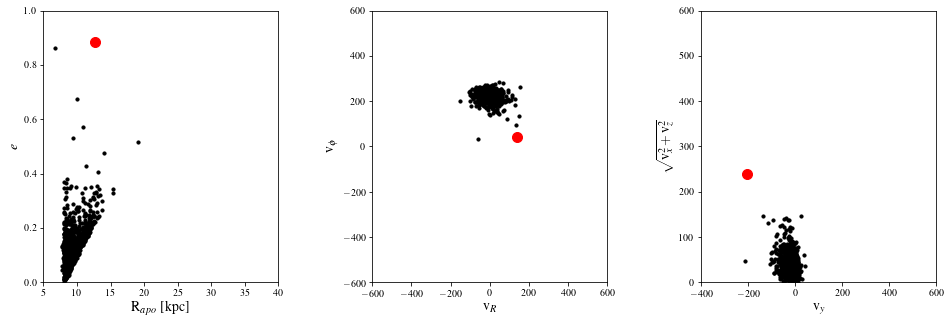

In [38]:
# check their E-Lz distribution and abundances

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.scatter(apo,ecc,s=10,c='k')
plt.scatter(apo[mask_gesplanet],ecc[mask_gesplanet],s=100,c='r')
plt.xlabel(r'R$_{apo}$ [kpc]', fontsize=14)
plt.ylabel(r'$e$', fontsize=14)
plt.xlim(5,40)
plt.ylim(0,1)


plt.subplot(1,3,2)
plt.scatter(vR,vphi,s=10,c='k')
plt.scatter(vR[mask_gesplanet],vphi[mask_gesplanet],s=100,c='r')
plt.xlabel(r'v$_{R}$', fontsize=14)
plt.ylabel(r'v$_{\phi}$', fontsize=14)
plt.xlim(-600,600)
plt.ylim(-600,600)

plt.subplot(1,3,3)
plt.scatter(vy,np.sqrt(vx**2+vz**2),s=10,c='k')
plt.scatter(vy[mask_gesplanet],np.sqrt(vx**2+vz**2)[mask_gesplanet],s=100,c='r')
plt.xlabel(r'v$_{y}$', fontsize=14)
plt.ylabel(r'$\sqrt{\mathrm{v}_{x}^{2}+\mathrm{v}_{z}^{2}}$', fontsize=14)
plt.xlim(-400,600)
plt.ylim(0,600)

plt.subplots_adjust(hspace=0.2,wspace=0.4)





In [14]:
import galpy
from galpy.util import bovy_coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.bovy_conversion import get_physical

# Let's re-run its orbits accounting for the uncertainties to see if its values are reliable

In [ ]:
ra = data['RA'][mask_gesplanet]
dec = data['DEC'][mask_gesplanet]
pmra = data['pmra'][mask_gesplanet]
pmdec = data['pmdec'][mask_gesplanet]
dist = data['weighted_dist'][mask_gesplanet]
rv = data['VHELIO_AVG'][mask_gesplanet]



In [ ]:
# create the covariance matrices

cov_gc = np.zeros([len(ra_gc),6,6])
cov_gc[:,0] = np.dstack([ra_err_gc**2, ra_err_gc*dec_err_gc*0., ra_err_gc*(dist_err_gc)*0.,\
                      ra_err_gc*pmra_err_gc*0., ra_err_gc*dec_err_gc*0., np.zeros(len(ra_gc))])[0]
cov_gc[:,1,1:] = np.dstack([dec_err_gc**2, dec_err_gc*(dist_err_gc)*0., dec_err_gc*pmra_err_gc*0.,\
                         dec_err_gc*pmdec_err_gc*0.,np.zeros(len(ra_gc))])[0]
cov_gc[:,2,2:] = np.dstack([(dist_err_gc)**2, (dist_err_gc)*pmra_err_gc*0., (dist_err_gc)*pmdec_err_gc*0.,\
                         np.zeros(len(ra_gc))])[0]
cov_gc[:,3,3:] = np.dstack([pmra_err_gc**2, pmra_err_gc*pmdec_err_gc*corr_coeff_gc, np.zeros(len(ra_gc))])[0]
cov_gc[:,4,4:] = np.dstack([pmdec_err_gc**2, np.zeros(len(ra_gc))])[0]
cov_gc[:,5,5] = vlos_err_gc**2
cov_gc[:,:,0] = cov_gc[:,0]
cov_gc[:,1:,1] = cov_gc[:,1,1:]
cov_gc[:,2:,2] = cov_gc[:,2,2:]
cov_gc[:,3:,3] = cov_gc[:,3,3:]
cov_gc[:,4:,4] = cov_gc[:,4,4:]

mean_gc = np.dstack([ra_gc,dec_gc,dist_gc,pmra_gc,pmdec_gc,vlos_gc])[0] 

# Try with potential planets

In [189]:
import pandas as pd
file = pd.read_csv('/Users/dhortadarrington/Downloads/TOIs_simple.txt')
np.savetxt('/Users/dhortadarrington/Downloads/TOIs_.txt',file,fmt='%s')

In [ ]:
# LOAD THE APOGEE DATA
path = '/Users/dhortadarrington/Documents/Master/data/MWM-ipl3-gaiadr3-APW_orbits_BJdist.fits'
tb = fits.open(path)
data_mw = tb[1].data

In [37]:
from astropy.io import ascii
data = ascii.read('/Users/dhortadarrington/Downloads/TOIs_simple.txt')

In [81]:
# convert angles to hexadecimal to decimal
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from astropy import units as u


c = SkyCoord(ra = data['ra'],dec = data['dec'],unit=(u.hourangle, u.deg))
print(len(c))

6977


In [58]:
# LOAD THE APOGEE DATA
path = '/Users/dhortadarrington/Documents/Master/data/MWM-ipl3-gaiadr3-APW_orbits_BJdist.fits'
tb = fits.open(path)
data_mw = tb[1].data 

In [61]:
c_mw = SkyCoord(ra=data_mw['ra'],dec=data_mw['dec'],unit=(u.deg, u.deg))
c_mw

<SkyCoord (ICRS): (ra, dec) in deg
    [(56.462902, 59.92747 ), (56.46357 , 31.997158),
     (58.064785, 18.301762), ..., (57.191647, -6.069128),
     (57.191875, 39.228138), (57.192642, 31.543196)]>

In [73]:
import astropy
matches_indx, sep2d, dist3d = astropy.coordinates.match_coordinates_sky(c_mw[~np.isnan(data_mw['ra'])],c,nthneighbor=1)


In [161]:
c

<SkyCoord (ICRS): (ra, dec) in deg
    [(318.737     , -55.87186389), ( 87.13983333, -63.98832778),
     (312.4575    , -24.42869444), ..., (327.238     , -40.08656944),
     ( 70.37170833, -60.40755556), (322.62204167, -26.77397222)]>

In [190]:
sep2d

<Angle [0.42805769, 0.18780894, 3.25613444, ..., 3.94800183, 2.00347602,
        0.9527672 ] deg>

In [191]:
mask = sep2d<0.05*u.arcsecond

In [192]:
print(len(data_mw['ra'][1:][mask]))

846


(-1.0, 1.0)

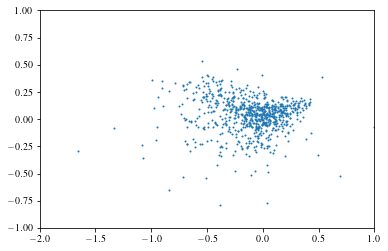

In [193]:
alfe = data_mw['al_h']-data_mw['fe_h']
mgfe = data_mw['mg_h']-data_mw['fe_h']

plt.scatter(data_mw['fe_h'][1:][mask],alfe[1:][mask],s=1)
plt.xlim(-2,1)
plt.ylim(-1,1)

(-1.0, 1.0)

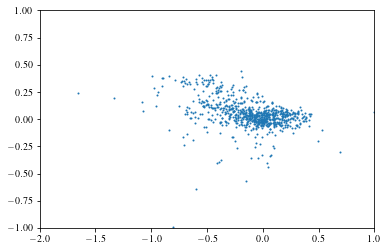

In [194]:
plt.scatter(data_mw['fe_h'][1:][mask],mgfe[1:][mask],s=1)
plt.xlim(-2,1)
plt.ylim(-1,1)

In [195]:
line = data_mw['fe_h'][1:]*-0.3 - 0.05

mask_halo = ((data_mw['FE_H'][1:]>-2)&(data_mw['FE_H'][1:]<-0.4)&(mgfe[1:]<line))


(-1.0, 1.0)

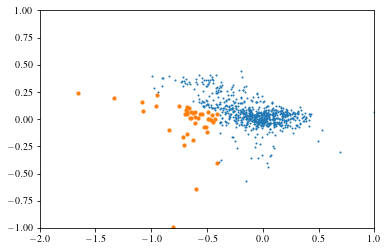

In [196]:
plt.scatter(data_mw['fe_h'][1:][mask],mgfe[1:][mask],s=1)
plt.scatter(data_mw['fe_h'][1:][mask&mask_halo],mgfe[1:][mask&mask_halo],s=10)
plt.xlim(-2,1)
plt.ylim(-1,1)

In [197]:
print(np.shape(data_mw['ecc'][1:,0]))


(1059520,)


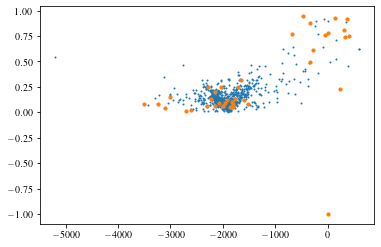

In [198]:
plt.scatter(data_mw['L'].T[2,1:][mask],data_mw['ecc'][1:,0][mask],s=1)
plt.scatter(data_mw['L'].T[2,1:][mask&mask_halo],data_mw['ecc'][1:,0][mask&mask_halo],s=10)


In [199]:
mask_halo2 = (data_mw['ecc'][1:,0]>0.8)
print(len(data_mw[1:][mask&mask_halo&mask_halo2]))

5


In [200]:
print(alfe[1:][mask&mask_halo&mask_halo2])
print(mgfe[1:][mask&mask_halo&mask_halo2])
print(data_mw['fe_h'][1:][mask&mask_halo&mask_halo2])
print(data_mw['ecc'][1:,0][mask&mask_halo&mask_halo2])

[-0.36002827 -0.20062816 -0.18831825 -0.2920283  -0.06795824]
[0.07605612 0.04987603 0.1248762  0.23777914 0.22009915]
[-1.0761633  -0.69498336 -0.9530734  -1.6525633  -0.9461334 ]
[0.92990216 0.81136349 0.91167685 0.94280316 0.87505958]


In [201]:
print(data_mw['gaia_dr3_source_id'][1:][mask&mask_halo&mask_halo2])

[4665623626480368640 4651312490534332416 4650369315698606720
 1000233188147566080 5292326395113144704]
